## Overview

Adaptive sparse grids constructed at Chebyshev nodes provide an efficient way to approximate functions of multiple variables. This nodebooks gives examples of how to build approximations for functions of two and three variables.

For details of the algorithm see Algorithm 5 of https://arxiv.org/abs/2307.08997 and the papers it is based off of

 * Bathelmann Volker, Novak Erich, Ritter Klaus. High dimensional polynomial interpolation
    on sparse grids // Advances in Computation Mathematics. 2000. 273-288
 * Gerstner Thomas, Griebel Michael. Dimension–Adaptive Tensor–Product Quadrature // Computing. 
    09 2003. 71. 65–87
 * Klimke Andreas. Uncertainty Modeling using Fuzzy Arithmetic and Sparse Grids. 01 2006. 40–41.
 * Jakeman John D., Roberts Stephen G. Local and Dimension Adaptive Sparse Grid Interpolation and 
    Quadrature. 2011

In [1]:
import numpy as np
from bbai.numeric import SparseGridInterpolator
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from collections import defaultdict

## Example 1: fit a function of 2 variables

In [2]:
def f(x, y):
    v1 = np.abs(x - 0.2)
    v2 = 2 * np.abs(y - 0.7)
    return np.exp(-v1 - v2)

In [3]:
interp = SparseGridInterpolator()
interp.fit(f)
pts = interp.points
print('num points =', pts.shape[1])

num points = 1794


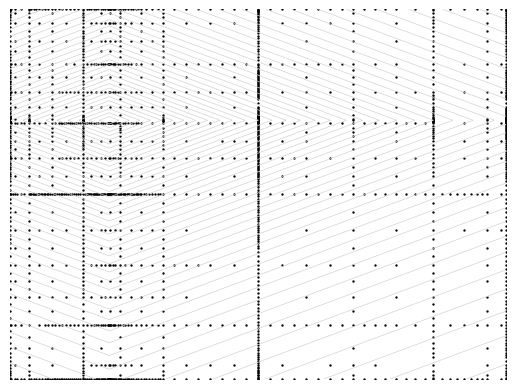

In [4]:
# Plot out the sparse grid points
N = 1000
xx = np.linspace(0, 1, N)
yy = np.linspace(0, 1, N)
X, Y = np.meshgrid(xx, yy)
Z = f(X, Y)
fig, ax = plt.subplots()
ax.axis('off')
ax.scatter(pts[0, :], pts[1, :], s=0.5, c='black')
ncontours = 50
ax.contour(X, Y, Z, ncontours, colors='lightgrey', linewidths=[0.5]*ncontours)

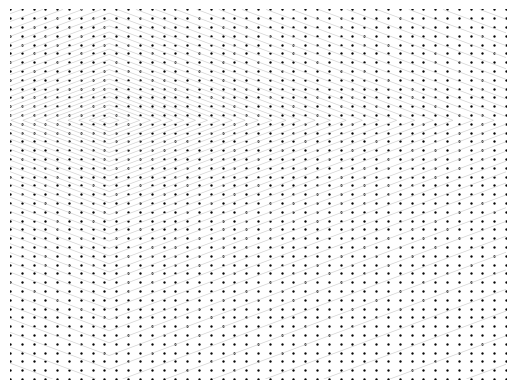

In [5]:
# For comparison, plot out points for a dense grid of similar size
density = 43
xx = np.linspace(0, 1, density)
yy = np.linspace(0, 1, density)
Xp, Yp = np.meshgrid(xx, yy)
fig, ax = plt.subplots()
ax.axis('off')
ax.scatter(Xp, Yp, s=0.5, c='black')
#ax.scatter(Xp, Yp, s=0.5, c='tab:red')
ncontours = 50
ax.contour(X, Y, Z, ncontours, colors='lightgrey', linewidths=[0.5]*ncontours)

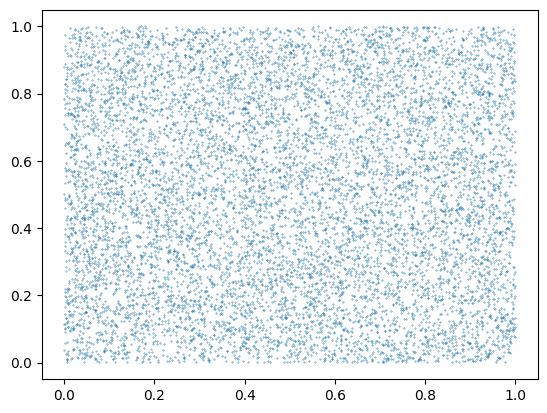

In [6]:
# Test the accuracy of the approximation at randomly distributed points
np.random.seed(0)
N = 10000
X = np.random.uniform(size=(N, 2))
plt.scatter(X[:,0], X[:, 1], s=0.1)

In [7]:
f_true = f(X[:,0], X[:, 1])
f_approx = interp.evaluate(X[:,0], X[:,1])
errs = np.abs(f_true - f_approx)
print('sparse grid mean/max error: ', np.mean(errs), np.max(errs))

sparse grid mean/max error:  6.104854255983044e-05 0.0009562678203793862


In [8]:
# For comparison also approximate using cubic splines on a dense grid
xx = np.linspace(0, 1, density)
yy = np.linspace(0, 1, density)
xg, yg = np.meshgrid(xx, yy, indexing='ij')
evals = f(xg, yg)
interp_p = RegularGridInterpolator((xx, yy), evals, method='cubic')
f_approx_p = interp_p(np.array([X[:, 0], X[:, 1]]).T)
errs_p = np.abs(f_true - f_approx_p)
print('dense grid mean/max error:', np.mean(errs_p), np.max(errs_p))

dense grid mean/max error: 0.00024614520681563674 0.01664113683843249


## Plot out error distributions for the sparse grid vs the cubic interpolation

In [9]:
from collections import defaultdict, namedtuple
import numpy as np

SummaryStats = namedtuple('SummaryStats', ['min', 'max', 'mean'])

def compute_range(errs):
    low = float("inf")
    high = -low
    for errs_i in errs:
        low = min(np.min(errs_i), low)
        high = max(np.max(errs_i), high)
    return low, high

def bin_errors(errs, bin_size, low):
    res = defaultdict(int)
    for err in errs:
        t = np.rint((err - low) / bin_size)
        res[t] += 1
    return res

def summary_stats(errs):
    min_err = np.min(errs)
    max_err = np.max(errs)
    mean_err = np.mean(errs)
    return SummaryStats(min_err, max_err, mean_err)

def points(bins, a, m):
    res = []
    for err, cnt in bins.items():
        for i in range(cnt):
            res.append((m * i + a, err))
    return np.array(res)

def plot_error_comparison(ax, left_errs, right_errs, nbins):
    left_stats = summary_stats(left_errs)
    right_stats = summary_stats(right_errs)
    left_errs = np.log(left_errs)
    right_errs = np.log(right_errs)
    low, high = compute_range((left_errs, right_errs))
    bin_size = (high - low) / nbins
    left_bins = bin_errors(left_errs, bin_size, low)
    right_bins = bin_errors(right_errs, bin_size, low)
    left_pts = points(left_bins, 0, -1)
    right_pts = points(right_bins, 1, 1)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.xaxis.set_ticks([])

    yticks = [
            left_stats.mean,
            right_stats.mean,
    ]
    for max_err in [left_stats.max, right_stats.max]:
        yticks.append(max_err)
    yticks.append(np.exp(low))
    ylabels = ['%0.2e' % x for x in yticks]
    ax.set_yscale('log')
    ax.yaxis.set_ticks(yticks)
    ax.yaxis.set_ticklabels(ylabels)
    ax.set_ylim(np.exp([low, high]))
    ax.yaxis.grid(color='white', linewidth=0.5)
    ax.tick_params(direction='in')

    ax.scatter(left_pts[:, 0], np.exp(left_pts[:, 1] * bin_size + low), s=0.5, c='tab:orange')
    ax.scatter(right_pts[:, 0], np.exp(right_pts[:, 1] * bin_size + low), s=0.5, c='tab:blue')

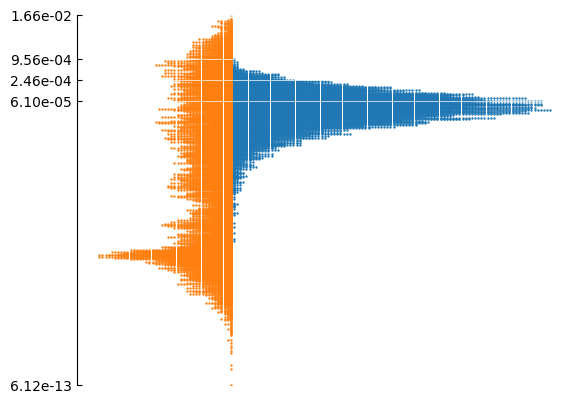

In [10]:
fig, ax = plt.subplots()
plot_error_comparison(ax, errs_p, errs, 1000)

## Example 2: fit a function of 3 variables

In [11]:
def f(x, y, z):
    v1 = np.abs(x - 0.2)
    v2 = 2 * np.abs(y - 0.7)
    v3 = 0.75 * np.abs(z - 0.4)
    return np.exp(-v1 - v2 - v3)

In [12]:
interp = SparseGridInterpolator()
interp.fit(f)
pts = interp.points
print('num points =', pts.shape[1])

num points = 7482


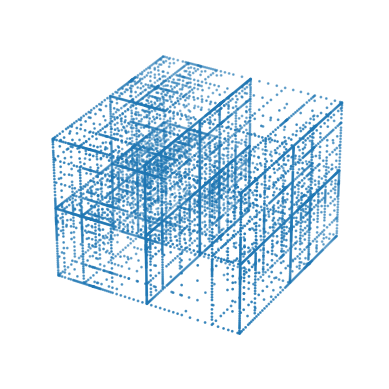

In [13]:
# Plot out the sparse grid points
ax = plt.axes(projection='3d')
ax.set_axis_off()
ax.scatter3D(pts[0, :], pts[1, :], pts[2,:], s=1)

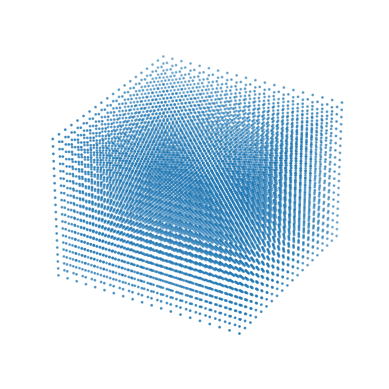

In [14]:
# Plot out points for a dense grid of similar size
density = 20
xs = np.linspace(0, 1, density)
pset = []
for xi in xs:
    for xj in xs:
        for xk in xs:
            pset.append((xi, xj, xk))
pset = np.array(pset).T
pset[2,:]
ax = plt.axes(projection='3d')
ax.set_axis_off()
ax.scatter3D(pset[0, :], pset[1, :], pset[2,:], s=1)

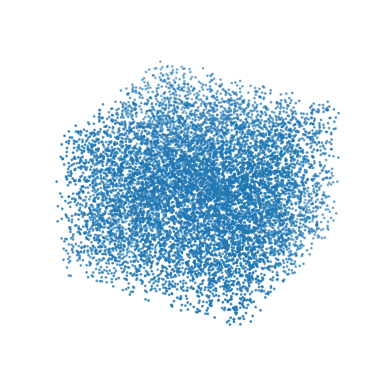

In [15]:
# Test the accuracy of the approximation at randomly distributed points
np.random.seed(0)
N = 10000
X = np.random.uniform(size=(N, 3))
ax = plt.axes(projection='3d')
ax.set_axis_off()
ax.scatter3D(X[:, 0], X[:, 1], X[:,2], s=1)

In [16]:
f_true = f(X[:,0], X[:, 1], X[:, 2])
f_approx = interp.evaluate(X[:,0], X[:,1], X[:,2])
errs = np.abs(f_true - f_approx)
print('sparse grid mean/max error:', np.mean(errs), np.max(errs))

sparse grid mean/max error: 6.12752698829316e-05 0.0006828208829067206


In [17]:
# For comparison also approximate using cubic splines on a dense grid
xx = np.linspace(0, 1, density)
yy = np.linspace(0, 1, density)
zz = np.linspace(0, 1, density)
xg, yg, zg = np.meshgrid(xx, yy, zz, indexing='ij')
evals = f(xg, yg, zg)
interp_p = RegularGridInterpolator((xx, yy, zz), evals, method='cubic')
f_approx_p = interp_p(np.array([X[:, 0], X[:, 1], X[:,2]]).T)
errs_p = np.abs(f_true - f_approx_p)
print('dense grid mean/max error:', np.mean(errs_p), np.max(errs_p))

dense grid mean/max error: 0.0009968456327451702 0.029785171555390955


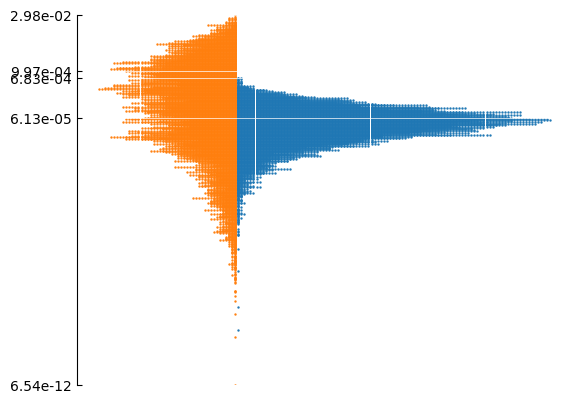

In [18]:
fig, ax = plt.subplots()
plot_error_comparison(ax, errs_p, errs, 1000)

In [19]:
# Compute the integral
print(interp.integral)

0.36533582812121873


## More Dimensions

In [20]:
N = 10000
dmax = 10
mult = np.array([0.2699884 , 0.35183688, 0.296529  , 0.26805488, 0.20841667,
       0.31774713, 0.21527071, 0.43870707, 0.47407319, 0.18863377])
offsets = np.array([0.79172504, 0.52889492, 0.56804456, 0.92559664, 0.07103606,
       0.0871293 , 0.0202184 , 0.83261985, 0.77815675, 0.87001215])

In [21]:
np.random.seed(0)
def fit_grid(d):
    def f(*args):
        n = len(args[0])
        t = np.zeros(n)
        for j, arg in enumerate(args):
            delta = arg - offsets[j]
            t -= mult[j] * delta * delta
        return np.exp(t)
    domain = [(0, 1)]*d
    interp = SparseGridInterpolator(tolerance=1.0e-4, ranges=domain)
    interp.fit(f)
    X = np.random.uniform(size=(N, d))
    args = [X[:, j] for j in range(d)]
    f_true = f(*args)
    f_approx = interp.evaluate(*args)
    errs = np.abs(f_true - f_approx)
    return interp.points.shape[1], np.mean(errs), np.max(errs)

In [22]:
num_points = []
mean_errs = []
max_errs = []
for d in range(1, dmax + 1):
    npoints, mean_err, max_err = fit_grid(d)
    num_points.append(npoints)
    mean_errs.append(mean_err)
    max_errs.append(max_err)

In [23]:
for d in range(dmax):
    print(d+1, num_points[d], mean_errs[d], max_errs[d])

1 9 2.3522581561463696e-10 4.763014427311418e-10
2 40 1.7058346600513642e-07 1.4239054521025807e-06
3 113 2.7433323588973434e-07 4.503403303601772e-06
4 315 5.027171167858557e-07 3.88287827768341e-06
5 674 1.0221822855358664e-06 9.651270844068804e-06
6 1419 1.6971499035800809e-06 1.866997052424324e-05
7 2682 2.5241102069248842e-06 3.4306753402768564e-05
8 5059 3.8027048225791837e-06 4.9330870812380745e-05
9 8857 6.384535111407374e-06 0.0001007933946625128
10 13256 8.114895986719667e-06 0.0001341782242915146


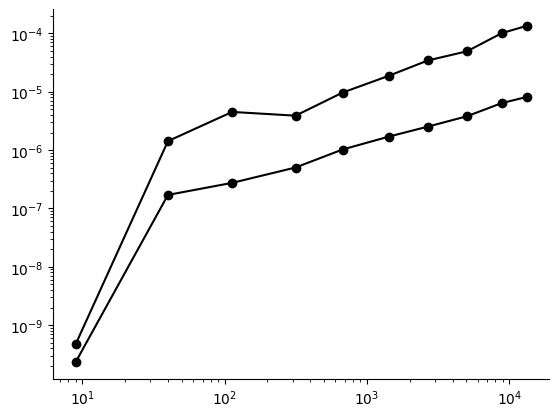

In [24]:
# Plot out the errors
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.plot(num_points, mean_errs, 'o-', c='black')
ax.plot(num_points, max_errs, 'o-', c='black')